# Dog Breed classification using AWS Sagemaker


This project is for determine the given dog image breed, the trained data have 133 dog breed which used for our model training, the project done using pytorch library throw sagemaker, and we used the transfer learning throw pretrained model which is resnet50 with modifing the outputs classes number to 133 as we have 133 dog breed classes.

The trained data in this project is more than 8000 dogs images with the different 133 breeds, and also we have validation & test images will be used to detemine the best model.




In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 881.9 MB 2.7 kB/s              B 108.4 MB/s eta 0:00:07


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import smdebug
import torch

## Dataset
The trained data in this project is more than 8000 dogs images with the different 133 breeds, and also we have validation & test images will be used to detemine the best model.

I already uploaded the data to s3 manually to be used in the training, validating and testing process. 

before using the data I did some processes to clean the data and resize the images to have similar size and tranform them to tensor to be provided to our algorithm.

In [ ]:
'''
Data already uploded to s3 manually
'''

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)

#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {"lr": ContinuousParameter(0.001, 0.1),
                        "batch-size": CategoricalParameter([64, 128, 256, 512])}


objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Test loss: ([0-9\\.]+)"}]

In [9]:
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='dog_breed_class_pytorch',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large")

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,)

In [ ]:
# TODO: Fit your HP Tuner
import os
os.environ["DEFAULT_S3_BUCKET"] = "s3://sagemaker-us-east-1-028490274912"

os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-028490274912/DogBreedClassification/dogImages/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-028490274912/DogBreedClassification/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-028490274912/DogBreedClassification/output/'


tuner.fit({"training": "s3://sagemaker-us-east-1-028490274912/DogBreedClassification/dogImages/"}, wait= True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-11-19 13:11:43 Starting - Found matching resource for reuse
2022-11-19 13:11:43 Downloading - Downloading input data
2022-11-19 13:11:43 Training - Training image download completed. Training in progress.
2022-11-19 13:11:43 Uploading - Uploading generated training model
2022-11-19 13:11:43 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"64"',
 'lr': '0.00212282770030206',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog_breed_class_pytorch-2022-11-19-12-11-38-779"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-028490274912/dog_breed_class_pytorch-2022-11-19-12-11-38-779/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [28]:
hyperparameters = {"batch-size": 64, "lr": 0.00212282770030206} 

In [29]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [   Rule.sagemaker(rule_configs.loss_not_decreasing()),
            ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
            ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
            Rule.sagemaker(rule_configs.vanishing_gradient()),
            Rule.sagemaker(rule_configs.overfit()),
            Rule.sagemaker(rule_configs.overtraining()),
            Rule.sagemaker(rule_configs.poor_weight_initialization()),]

In [30]:
profiler_config = ProfilerConfig( system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))

debugger_config = DebuggerHookConfig(collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",
                                     parameters={"include_regex": "CrossEntropyLoss_output_0",
                                     "train.save_interval": "100","eval.save_interval": "10"})])

In [60]:
# TODO: Create and fit an estimator




estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name='dogBreedPytorch',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    hyperparameters= hyperparameters,
    instance_type="ml.c5.2xlarge",
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config)


estimator.fit({"training": "s3://sagemaker-us-east-1-028490274912/DogBreedClassification/dogImages/"}, wait= True)

2022-11-19 16:29:50 Starting - Starting the training job...
2022-11-19 16:30:17 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-11-19 16:31:18 Downloading - Downloading input data......
2022-11-19 16:32:18 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-19 16:32:16,924 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-19 16:32:16,926 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-19 16:32:16,934 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-19 16:32:16,941 sagemaker_pytorch_container.training INFO    

In [61]:
# TODO: Plot a debugging output.

import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")



trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: dogBreedPytorch-2022-11-19-16-29-49-803
Region: us-east-1
[2022-11-19 17:21:16.313 ip-172-16-49-35.ec2.internal:11992 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-028490274912/dogBreedPytorch-2022-11-19-16-29-49-803/debug-output
[2022-11-19 17:21:17.214 ip-172-16-49-35.ec2.internal:11992 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-11-19 17:21:18.239 ip-172-16-49-35.ec2.internal:11992 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0'

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


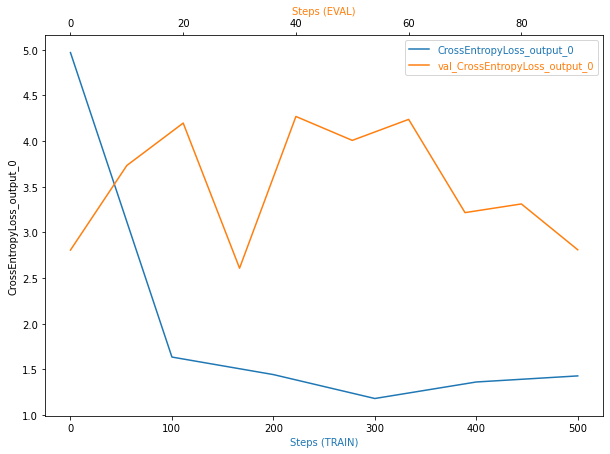

In [63]:
plot_tensor(trial, "CrossEntropyLoss_output_0");

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?

As show at the above graph our model have two problems, the first problem is overfitting, becuase the training loss decreasing.
the second problem is: very high learing rate value used as a hyperparameter, as we see in the first 100 steps the error reduced from 5 to 1.5, and in the following steps it increased.

So, I need to use low learing rate value to improve the model results.

In [64]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [65]:
! aws s3 ls {rule_output_path} --recursive

2022-11-19 17:20:59     387157 dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-11-19 17:20:58     237185 dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-11-19 17:20:53        192 dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-11-19 17:20:53        200 dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-11-19 17:20:53       2087 dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-11-19 17:20:53        127 dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-11-19 17:20:53        199 dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/I

In [66]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-028490274912/dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-028490274912/dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-028490274912/dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-028490274912/dogBreedPytorch-2022-11-19-16-29-49-803/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-028490274912/dogBreedPyto

In [67]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]][0]

In [68]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [91]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-east-1-028490274912/dogBreedPytorch-2022-11-19-16-29-49-803/output/model.tar.gz'

In [4]:
model_location= 's3://sagemaker-us-east-1-028490274912/dogBreedPytorch-2022-11-19-16-29-49-803/output/model.tar.gz'

In [5]:
import sagemaker
import boto3

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.session.Session()
sagemaker_session.default_bucket() 


'sagemaker-us-east-1-028490274912'

In [14]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name,
                                             sagemaker_session=sagemaker_session,
                                             serializer=jpeg_serializer,
                                             deserializer=json_deserializer)

In [15]:
import numpy as np
from PIL import Image
import io


def get_label(file):
    removed_str= "s3://sagemaker-us-east-1-028490274912/DogBreedClassification/dogImages/test/"
    cr= len(removed_str)
    label = int(file[cr:cr+3])
    return label

def get_breed(file):
    removed_str= "s3://sagemaker-us-east-1-028490274912/DogBreedClassification/dogImages/test/"
    cr= len(removed_str)
    str= file[cr+4:]
    cr_stop=int(str.index("/"))
    breed = str[:cr_stop]
    return breed

def plot_result(response, file, image):
    pred_label= np.argmax(response)+1
    actual_label= get_label(file)
    breed_name= get_breed(file)
    img = Image.open(image)
    plt.imshow(img);
    plt.show();
    print(f"\nactual breed is: {breed_name}\nactual label is: {actual_label}\npredicted label is: {pred_label}")



In [16]:
# TODO: Deploy your model to an endpoint

model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py', py_version='py36',
                             framework_version='1.8', predictor_cls=ImagePredictor)

predictor=model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge') # TODO: Add your deployment configuration like instance type and number of instances

-----!

In [17]:
predictor.endpoint_name

'pytorch-inference-2022-11-21-07-25-03-176'

In [20]:
# TODO: Run an prediction on the endpoint
with open("test/German_shepherd_dog_04931.jpg" , 'rb') as f :
    image = f.read()


response = predictor.predict(image, initial_args={'ContentType':'image/jpeg'})

In [21]:
response

[[0.33077263832092285,
  -0.04765687510371208,
  -0.2682463526725769,
  -0.10281594842672348,
  0.05219334363937378,
  0.6798934936523438,
  0.12102742493152618,
  0.12954258918762207,
  0.1960415244102478,
  0.22833487391471863,
  0.5759081840515137,
  -0.14942610263824463,
  0.25169000029563904,
  -0.10312953591346741,
  -0.007050514221191406,
  0.5166608691215515,
  0.11740683019161224,
  -0.1648651361465454,
  -0.07064516097307205,
  0.22257976233959198,
  0.18323735892772675,
  0.0324401780962944,
  -0.21050584316253662,
  -0.09292488545179367,
  -0.722480297088623,
  -0.42428332567214966,
  0.15857842564582825,
  -0.09197919070720673,
  0.5174973011016846,
  -0.29395338892936707,
  0.3206815719604492,
  0.08091794699430466,
  -0.12518393993377686,
  0.05858401209115982,
  -0.06379321217536926,
  0.07680369913578033,
  -0.5044015049934387,
  -0.03701455891132355,
  0.3132797181606293,
  -0.24547532200813293,
  -0.07174865156412125,
  -0.23584170639514923,
  -0.4363085627555847,
  

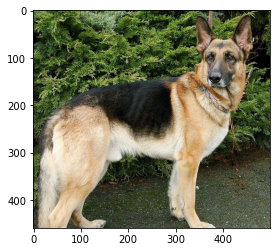


actual breed is: German_shepherd_dog
actual label is: 71
predicted label is: 6


In [22]:
import matplotlib.pyplot as plt
file= "s3://sagemaker-us-east-1-028490274912/DogBreedClassification/dogImages/test/071.German_shepherd_dog/German_shepherd_dog_04931.jpg"
img= "test/German_shepherd_dog_04931.jpg"
plot_result(response, file, img)

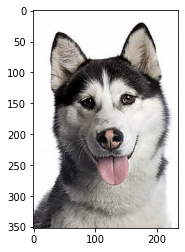


actual breed is: Alaskan_malamute
actual label is: 5
predicted label is: 98


In [23]:
with open("test/Alaskan_malamute_00330.jpg" , 'rb') as f :
    image = f.read()

file="s3://sagemaker-us-east-1-028490274912/DogBreedClassification/dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00330.jpg"
img= "test/Alaskan_malamute_00330.jpg"
response = predictor.predict(image, initial_args={'ContentType':'image/jpeg'})
plot_result(response, file, img)

In [24]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()